In [10]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

In [11]:
df_labels = pd.read_csv('csvjoinv2/as19981231.join.node.csv')
df_features = pd.read_csv('../../network_specs/as19981231.specs.csv', sep=';')

#df_features.drop(columns='state', inplace=True)

In [12]:
df_labels['State'] = np.where(
    df_labels['State'] == 'Recovered',
    0,
    1
)

In [13]:
df_labels['State'].value_counts()

0    317263
1      2737
Name: State, dtype: int64

In [14]:
df_labels['Id'].value_counts()

6122    625
8047    625
7657    625
8210    625
87      625
       ... 
6755    625
47      625
174     625
1221    625
93      625
Name: Id, Length: 512, dtype: int64

In [15]:
df_no_recover_proba = df_labels.groupby('Id')['State'].mean().reset_index(drop=False)
df_no_recover_proba

,Id,State
0,1,0.000
1,3,0.000
2,4,0.048
3,6,0.000
4,7,0.000
...,...,...
507,11427,0.000
508,11492,0.000
509,11563,0.000
510,11589,0.000


In [16]:
df_data = df_no_recover_proba.merge(
    df_features,
    on='Id',
    how='left'
)

In [17]:
df_data['binary_state'] = df_data['State'] > 0.0

In [18]:
folder = './jsonDataReport'
roundData = {}

files = os.listdir(folder)
for fname in files:    
        with open(folder+'/'+fname, "r") as f:
            data = json.load(f)  
        node_nneigh = []
        for node_id, node_data in data['0'].items():
            node_data_small = {
                'Id': node_id,
                'nneighWithNodeInfo': node_data['nneighWithNodeInfo']
            }
            node_nneigh.append(node_data_small)
        df_nneigh = pd.DataFrame(node_nneigh)  
        break
        
df_nneigh.head() #nneighWithNodeInfo

,Id,nneighWithNodeInfo
0,2548,275
1,4969,59
2,10656,4
3,1335,30
4,1334,32


In [19]:
df_data['Id'] = df_data['Id'].astype(str)
df_data = df_data.merge(df_nneigh, on='Id', how='left')

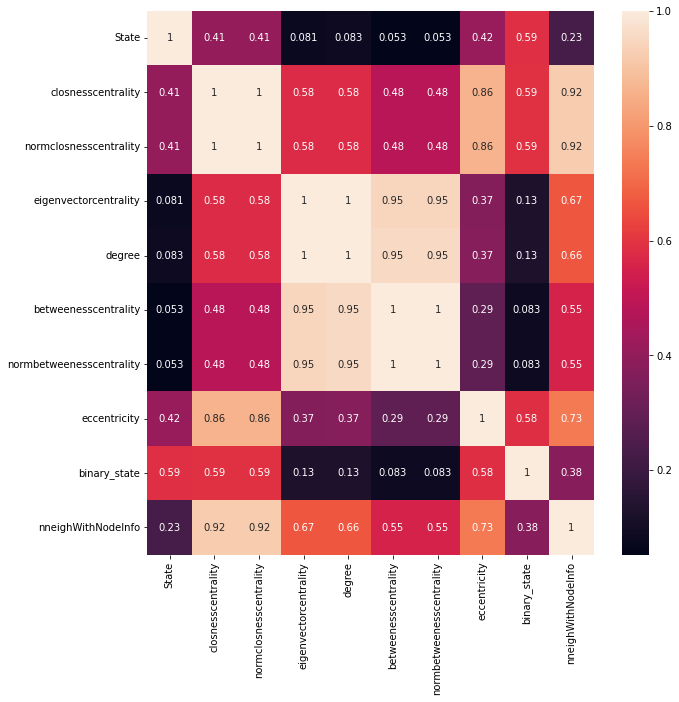

In [20]:
plt.figure(figsize=(10,10))
sns.heatmap(np.abs(df_data.corr()), annot=True)
plt.show()

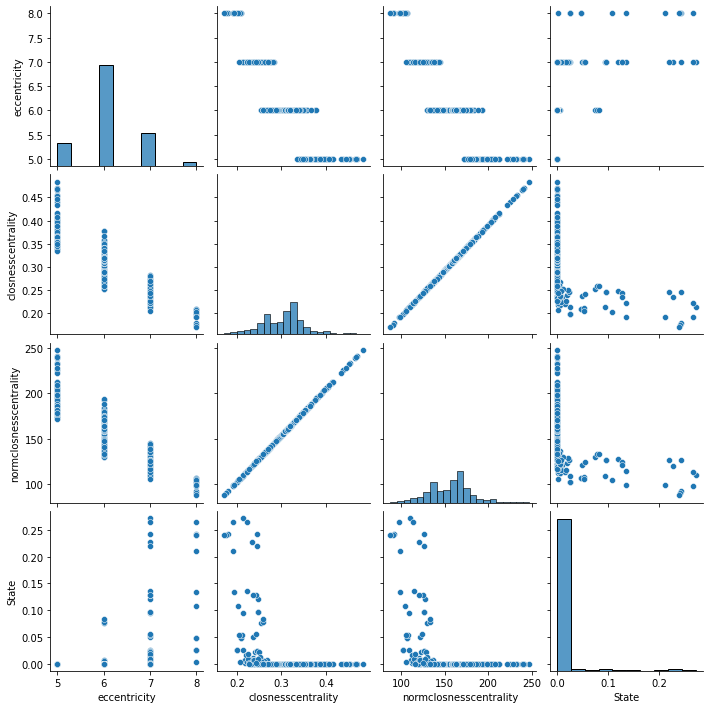

In [21]:
sns.pairplot(
    data=df_data[
        ['eccentricity',
         'closnesscentrality',
         'normclosnesscentrality',
         'State'
        ]
    ]
)

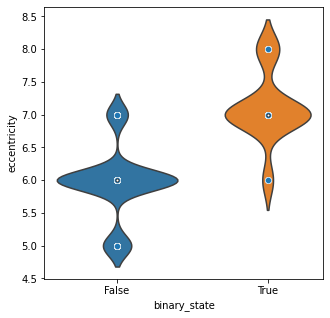

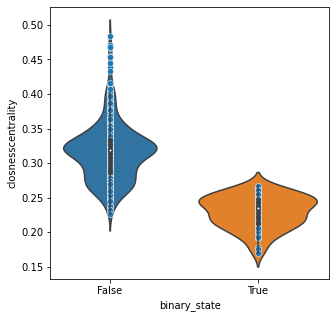

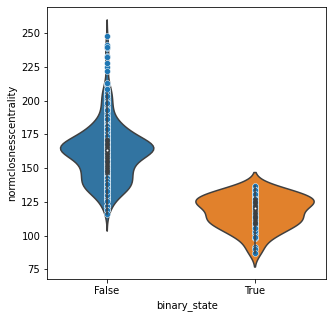

In [22]:
for col in ['eccentricity',
         'closnesscentrality',
         'normclosnesscentrality']:
    plt.figure(figsize=(5,5))
    sns.violinplot(
        data=df_data,
        y=col,
        x='binary_state'
    )
    sns.scatterplot(
        data=df_data,
        y=col,
        x='binary_state'
    )
    plt.show()

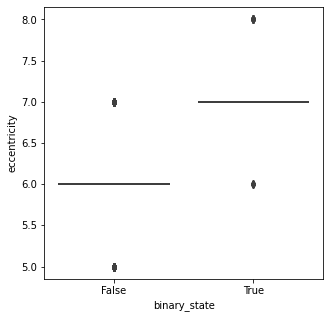

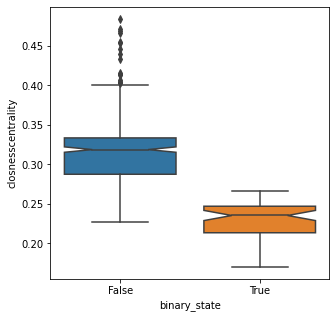

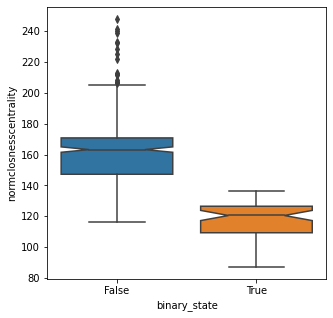

In [23]:
for col in ['eccentricity',
         'closnesscentrality',
         'normclosnesscentrality']:
    plt.figure(figsize=(5,5))
    sns.boxplot(
        data=df_data,
        y=col,
        x='binary_state',
        notch=True
    )
    plt.show()

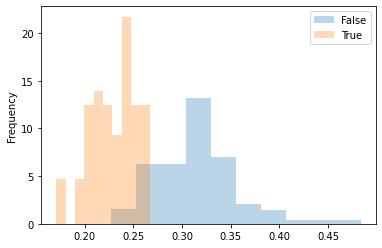

In [24]:
df_data.groupby('binary_state')['closnesscentrality'].plot(kind='hist', alpha=0.3, density=True)
plt.legend(loc='best')

In [25]:
joined_result_folder = '../joined_boxplot'

if not os.path.exists(joined_result_folder):
    os.mkdir(joined_result_folder)
    
df_data.to_pickle(f'{joined_result_folder}/as19981231.pkl')

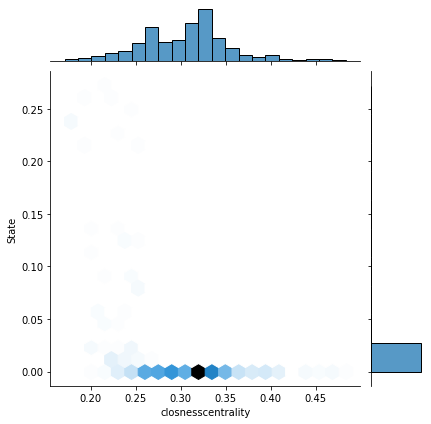

In [26]:
sns.jointplot(
    data=df_data,
    x='closnesscentrality',
    y='State',
   # hue='binary_state',
    #alpha=0.6,
    kind="hex"
    #kind="reg",
     #logx=True
)
    

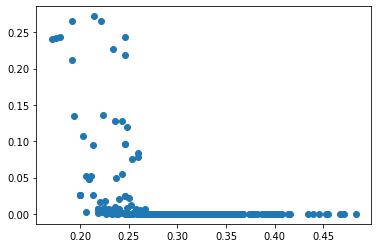

In [27]:
plt.scatter(
    x=df_data['closnesscentrality'],
    y=df_data['State'],
)


## History nneighbor vs final status

In [5]:
import json

In [6]:
folder = './jsonDataReport'
files = os.listdir(folder)
roundData = {}
missing_nodes = {}
files = os.listdir(folder)
node_histories_final_status = {}
for filenumber, fname in enumerate(files[:5]):
    formatted_fname = folder+'/'+fname
    with open(formatted_fname, "r") as f:
        data = json.load(f)

        valid_round_numbers = []
        for round_number in data.keys():
            if round_number.isnumeric():
                valid_round_numbers.append(round_number)
        data = {int(k): v for k, v in data.items() if k in valid_round_numbers}
        
        last_round_number = sorted(data.keys())[-1]
        
        node_statuses = data[last_round_number]
        
        for round_number in sorted(data.keys()):
            for node, node_info in data[round_number].items():
                if node not in node_histories_final_status.keys():
                    node_histories_final_status[node] = {'nneighWithNodeInfo': [], 'status': []}
                node_nneighWithNodeInfo = node_info['nneighWithNodeInfo']
                node_status = node_statuses[node]['status']

                node_histories_final_status[node]['nneighWithNodeInfo'].append(node_nneighWithNodeInfo)
                node_histories_final_status[node]['status'].append(node_status)
    if (filenumber % 10) == 0:
        print(f"Processed {filenumber} files out of {len(files)}")

Processed 0 files out of 200


In [7]:
node_statuses = []
node_nneighbors = []
round_numbers = []

for node_number, node_history in enumerate(node_histories_final_status.values()):
    node_statuses.extend(
        node_history['status']
    )
    node_nneighbors.extend(
        node_history['nneighWithNodeInfo']
    )
    round_numbers.extend(
        np.arange(
            len(node_history['status'])
        )
    )

df_history_final_status = pd.DataFrame({
    'status': node_statuses,
    'nneighWithNodeInfo': node_nneighbors,
    'round_number': round_numbers
})

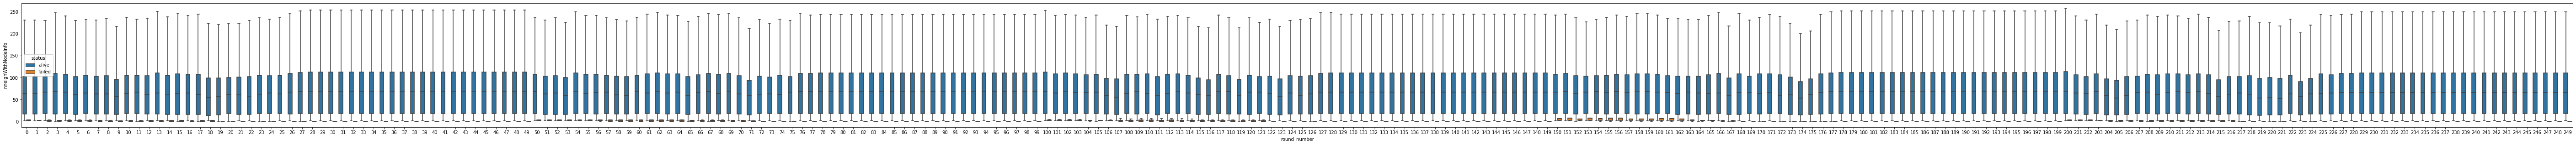

In [12]:
plt.figure(figsize=(100,5))
sns.boxplot(
    data=df_history_final_status,
    x='round_number',
    y='nneighWithNodeInfo',
    hue='status',
    showfliers=False
)
plt.show()

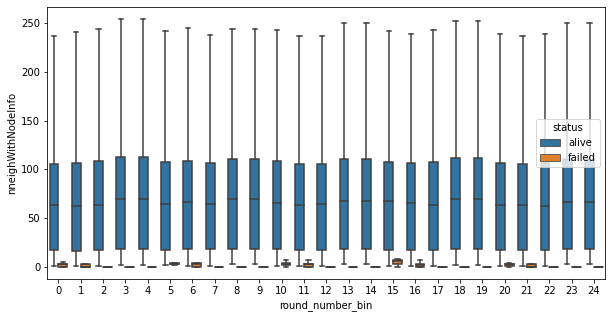

In [14]:
df_history_final_status['round_number_bin'] = df_history_final_status['round_number'] // 10
plt.figure(figsize=(10,5))
sns.boxplot(
    data=df_history_final_status,
    x='round_number_bin',
    y='nneighWithNodeInfo',
    hue='status',
    showfliers=False
)
plt.show()